# Test fitting an exponentially damped noisy sine wave with a 2nd order ODE

Import the libraries.

In [1]:
import os
import sys

from IPython.display import HTML
import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib import pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

torch.set_printoptions(precision=4, linewidth=500, sci_mode=True)

%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['animation.ffmpeg_path'] = '/nfs/scistore19/alistgrp/jiachen/ffmpeg/ffmpeg'

Import the S-MNN module.

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__) if '__file__' in globals() else '', '..', '..')))
from smnn import ode_forward

## Helper Functions

### Data Processing

In [3]:
class SineDataset(Dataset):
    def __init__(self, end, n_step, device):
        self.x = torch.linspace(0., end, n_step, dtype=torch.float64, device=device)
        self.y = ((self.x * 2.).sin() + torch.randn_like(self.x) * .5) * (-.1 * self.x).exp()

    def __len__(self):
        return 1

    def __getitem__(self, _):
        return self.y

In [4]:
class SineDataModule(pl.LightningDataModule):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def train_dataloader(self):
        return DataLoader(self.dataset, shuffle=True)

### Model Definition

In [5]:
class Model(pl.LightningModule):
    def __init__(self, device):
        super().__init__()
        step_size = .1
        n_step = 500
        end = n_step * step_size
        self.datamodule = SineDataModule(dataset=SineDataset(end=end, n_step=n_step, device=device))
        order = 2
        self.coefficients = nn.Parameter(torch.rand(1, 1, n_step, 1, 1, order + 1, dtype=torch.float64, device=device))
        self.rhs_equation = torch.ones(1, 1, n_step, 1, dtype=torch.float64, device=device)
        self.init_vars = torch.empty(1, 1, 0, 1, 0, dtype=torch.float64, device=device)
        self.steps = nn.Parameter(torch.tensor(step_size, dtype=torch.float64, device=device).logit().repeat(1, 1, n_step - 1))
        self.func_list = []

    def forward(self):
        steps = self.steps.sigmoid()

        u = ode_forward(self.coefficients, self.rhs_equation, self.init_vars, steps, is_step_dim_first=False, enable_central_smoothness=False)
        u0 = u[..., 0, 0]

        eps = torch.zeros(1, dtype=u.dtype, device=u.device)

        return eps, u0

    def training_step(self, y, _):
        eps, u0 = self.forward()
        loss = (u0 - y).pow(2).sum()
        self.log('train_loss', loss, prog_bar=True, logger=True)
        self.log('eps', eps, prog_bar=True, logger=True)
        self.func_list.append(u0.detach().cpu().numpy())
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-2)

    def do_train(self):
        trainer = pl.Trainer(
            max_epochs=500,
            accelerator='gpu' if torch.cuda.is_available() else 'cpu',
            devices=1,
            log_every_n_steps=1,
        )
        trainer.fit(self, datamodule=self.datamodule)

## Running Experiment

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Initialize the model.

In [7]:
model = Model(device=device)

Train the model.

In [8]:
model.do_train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/nfs/scistore19/alistgrp/jiachen/micromamba/envs/smnn/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.

Epoch 499: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.28it/s, v_num=6, train_loss=5.950, eps=0.000]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.07it/s, v_num=6, train_loss=5.950, eps=0.000]


Plot animations.

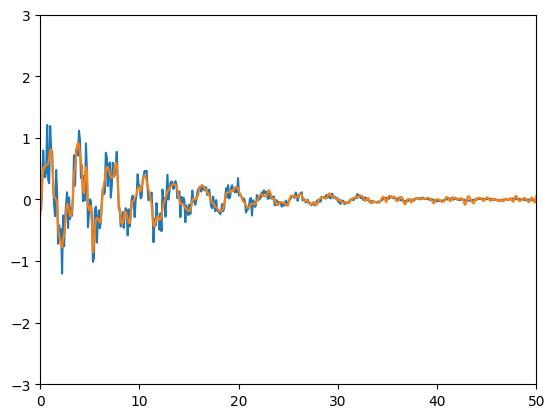

In [9]:
x = model.datamodule.dataset.x.detach().cpu().numpy()
y = model.datamodule.dataset.y.detach().cpu().numpy()
func_list = model.func_list

fig, ax = plt.subplots(1, 1)
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(-3., 3.)

line1, = ax.plot([], [])
line2, = ax.plot([], [])

def animate(t):
    line1.set_data(x, y)
    line2.set_data(x, func_list[t * 2])
    return line1,

anim = FuncAnimation(fig, animate, frames=250, interval=20, blit=True)
HTML(anim.to_html5_video())